In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc_marketing
from pymc_marketing import mmm
from pymc_marketing.mmm import MMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation,hill_saturation_sigmoid
from pymc_marketing.mmm import SaturationTransformation
from pymc_marketing.mmm import HillSaturation
from pymc_marketing.mmm import GeometricAdstock
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [155]:
df = pd.read_csv("synthetic_mmm_data.csv", parse_dates=['date'])
df

,date,channel_type,regions,cost
0,2020-01-06,Facebook_newsfeed,SG,7803.532318
1,2020-01-13,Facebook_newsfeed,SG,19038.928975
2,2020-01-20,Facebook_newsfeed,SG,14773.881865
3,2020-01-27,Facebook_newsfeed,SG,12173.840442
4,2020-02-03,Facebook_newsfeed,SG,3542.363489
...,...,...,...,...
8315,2023-11-27,Tiktok,KR,19270.915141
8316,2023-12-04,Tiktok,KR,18450.586383
8317,2023-12-11,Tiktok,KR,2562.044230
8318,2023-12-18,Tiktok,KR,18036.061592


In [142]:
df_rev= pd.read_csv("synthetic_mmm_revenue.csv", parse_dates=['date'])
df_rev

,date,regions,revenue
0,2020-01-06,SG,13655.943660
1,2020-01-13,SG,14393.384281
2,2020-01-20,SG,13859.473412
3,2020-01-27,SG,15256.676906
4,2020-02-03,SG,13413.824882
...,...,...,...
1035,2023-11-27,KR,15206.705795
1036,2023-12-04,KR,13475.711973
1037,2023-12-11,KR,13352.325008
1038,2023-12-18,KR,13650.927972


# decompose seasonality and trend, then adjust revenue

In [145]:
df_aggregated = df_rev.groupby('date')['revenue'].sum().reset_index()


In [146]:
df_aggregated

,date,revenue
0,2020-01-06,70302.042269
1,2020-01-13,71267.665082
2,2020-01-20,73226.231678
3,2020-01-27,74124.220486
4,2020-02-03,70494.830988
...,...,...
203,2023-11-27,70413.485107
204,2023-12-04,70228.758729
205,2023-12-11,69320.247381
206,2023-12-18,70694.316569


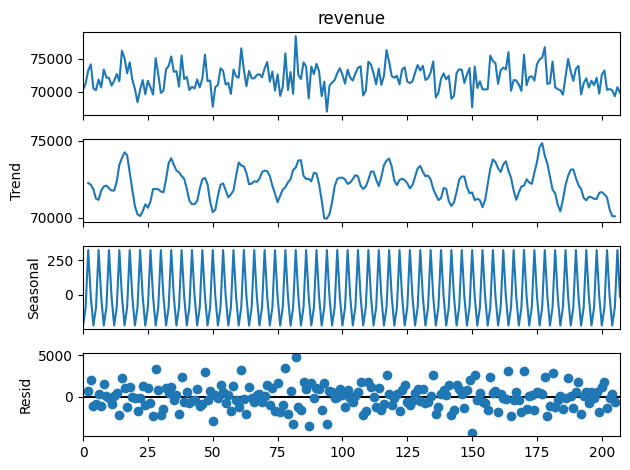

In [98]:
result_quarterly = seasonal_decompose(df_aggregated['revenue'], model='additive', period=4)  # Quarterly seasonality 
result_quarterly.plot()
plt.show()

quarterly_seasonal = result_quarterly.seasonal

In [99]:
detrended_quarterly_revenue = df_aggregated['revenue']-quarterly_seasonal

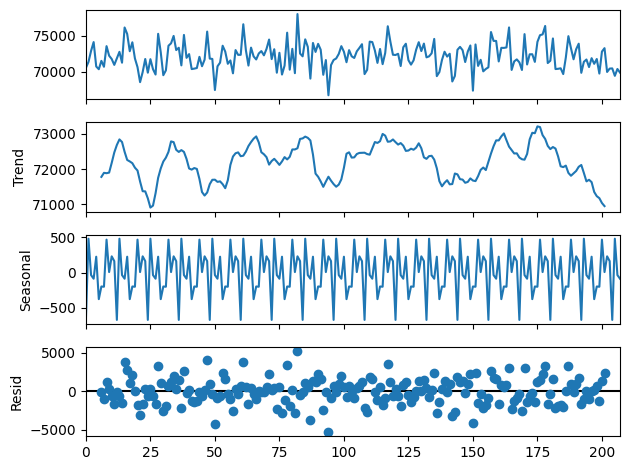

In [100]:
result_annual = seasonal_decompose(detrended_quarterly_revenue, model='additive', period=12)  # Annual seasonality (period=12 for monthly data)
result_annual.plot()
plt.show()

# Extract Annual Seasonal 
annual_seasonal = result_annual.seasonal

annual_adjusted_revenue = detrended_quarterly_revenue-annual_seasonal


In [101]:
# Linear regression to capture the trend
time = np.arange(len(df_aggregated)).reshape(-1, 1)
model = LinearRegression()
model.fit(time, annual_adjusted_revenue)

# Predicted trend
predicted_trend = model.predict(time)
intercept = model.intercept_  # This is β₀ (the intercept)
slope = model.coef_  # This is β₁ (the slope)



In [149]:
adjustment= quarterly_seasonal+annual_seasonal+predicted_trend-intercept


In [103]:
unique_channel_types = df['channel_type'].nunique()

In [122]:
df['channel_type'].unique()

array(['Facebook_newsfeed', 'Instagram_influencer', 'SEM_brand',
       'SEM_non_brand', 'Google_display', 'PMAX', 'Youtube', 'Tiktok'],
      dtype=object)

In [151]:
df_aggregated['adjustment'] = adjustment 

In [152]:
df_rev = df_rev.merge(df_aggregated[['date', 'adjustment']], on='date', how='left')


df_rev['adjusted_revenue'] = df_rev['revenue'] - df_rev['adjustment']



In [154]:
df_rev

,date,regions,revenue,adjustment,adjusted_revenue
0,2020-01-06,SG,13655.943660,-892.869633,14548.813293
1,2020-01-13,SG,14393.384281,388.799464,14004.584817
2,2020-01-20,SG,13859.473412,288.563700,13570.909712
3,2020-01-27,SG,15256.676906,-101.285995,15357.962901
4,2020-02-03,SG,13413.824882,0.696682,13413.128201
...,...,...,...,...,...
1035,2023-11-27,KR,15206.705795,62.379189,15144.326606
1036,2023-12-04,KR,13475.711973,-979.821626,14455.533600
1037,2023-12-11,KR,13352.325008,301.847471,13050.477537
1038,2023-12-18,KR,13650.927972,201.611707,13449.316264


In [157]:
df_rev=df_rev.drop('revenue', axis=1) 
df_rev=df_rev.drop('adjustment', axis=1)   


# MMM for SG


In [147]:
df_pivot = df.pivot(index=['date', 'regions'], columns='channel_type', values='cost')
df_pivot.reset_index(inplace=True)


In [148]:
df_pivot

channel_type,date,regions,Facebook_newsfeed,Google_display,Instagram_influencer,PMAX,SEM_brand,SEM_non_brand,Tiktok,Youtube
0,2020-01-06,HK,16644.285212,5522.786259,7969.780684,6785.924321,14840.573497,5443.370684,14919.929920,1697.428371
1,2020-01-06,JP,1857.352758,15881.032527,13225.130248,19054.005697,2023.051145,10375.922136,1448.292096,12644.394226
2,2020-01-06,KR,12471.476132,14999.260487,3803.762934,19520.493207,14535.187938,14382.604524,5884.794581,1936.641023
3,2020-01-06,MY,15768.666529,1228.630373,17752.064819,4977.444852,692.813368,8822.520753,13825.242614,1953.783010
4,2020-01-06,SG,7803.532318,10050.824426,11413.149328,5911.694696,4608.746795,8290.616299,18442.219360,18437.483216
...,...,...,...,...,...,...,...,...,...,...
1035,2023-12-25,HK,16502.234172,706.844756,19086.961996,6816.743539,958.297245,8129.898680,12714.128069,3465.164692
1036,2023-12-25,JP,538.259357,8986.865948,18293.995886,15095.611389,18362.614938,12860.514263,18974.262684,5979.186855
1037,2023-12-25,KR,14615.403161,16541.202091,3333.362337,15813.541928,19726.388791,831.797057,17871.916757,3674.151201
1038,2023-12-25,MY,10276.186168,5873.858051,1415.603765,15702.612151,18569.116297,15353.869593,14177.158943,8092.542708


In [161]:
merged_df = pd.merge(df_rev, df_pivot, on=['date', 'regions'], how='left')
merged_df

,date,regions,adjusted_revenue,Facebook_newsfeed,Google_display,Instagram_influencer,PMAX,SEM_brand,SEM_non_brand,Tiktok,Youtube
0,2020-01-06,SG,14548.813293,7803.532318,10050.824426,11413.149328,5911.694696,4608.746795,8290.616299,18442.219360,18437.483216
1,2020-01-13,SG,14004.584817,19038.928975,10808.803778,690.531525,18701.555977,19170.236371,6872.496764,9670.776342,1575.553517
2,2020-01-20,SG,13570.909712,14773.881865,7021.629279,6865.995511,14608.924180,672.834060,710.816131,1065.436515,16502.510427
3,2020-01-27,SG,15357.962901,12173.840442,10626.597507,10595.377046,11755.140186,19957.506686,16617.745947,13951.510891,1235.099113
4,2020-02-03,SG,13413.128201,3542.363489,4352.340161,2213.396733,13130.541061,13698.015328,16119.123658,9895.826445,7659.807701
...,...,...,...,...,...,...,...,...,...,...,...
1035,2023-11-27,KR,15144.326606,4889.388651,12436.621929,14601.995591,18019.307059,8496.253511,7520.763056,19270.915141,13881.473901
1036,2023-12-04,KR,14455.533600,8698.878984,12471.782141,16728.945409,7139.569913,1868.697991,16705.260730,18450.586383,6581.633948
1037,2023-12-11,KR,13050.477537,6924.272531,12336.201151,5465.012328,19656.190942,13435.053937,15027.306026,2562.044230,5161.883252
1038,2023-12-18,KR,13449.316264,10991.288808,11406.701175,4242.913613,19207.908181,7844.198499,5891.131775,18036.061592,16544.817981


In [166]:
merged_df_sg = merged_df[merged_df['regions'] == 'SG']
merged_df_sg= merged_df_sg.drop('regions', axis=1) 

In [167]:
X = merged_df_sg.drop('adjusted_revenue', axis=1)  
y = merged_df_sg['adjusted_revenue']  

In [168]:
X

,date,Facebook_newsfeed,Google_display,Instagram_influencer,PMAX,SEM_brand,SEM_non_brand,Tiktok,Youtube
0,2020-01-06,7803.532318,10050.824426,11413.149328,5911.694696,4608.746795,8290.616299,18442.219360,18437.483216
1,2020-01-13,19038.928975,10808.803778,690.531525,18701.555977,19170.236371,6872.496764,9670.776342,1575.553517
2,2020-01-20,14773.881865,7021.629279,6865.995511,14608.924180,672.834060,710.816131,1065.436515,16502.510427
3,2020-01-27,12173.840442,10626.597507,10595.377046,11755.140186,19957.506686,16617.745947,13951.510891,1235.099113
4,2020-02-03,3542.363489,4352.340161,2213.396733,13130.541061,13698.015328,16119.123658,9895.826445,7659.807701
...,...,...,...,...,...,...,...,...,...
203,2023-11-27,18021.806676,9764.613116,7645.999930,14679.674790,9939.502859,4908.541885,6642.661366,14520.944998
204,2023-12-04,12325.366663,8027.993245,8225.367486,19624.842901,15075.165929,16437.453588,11723.215403,10325.831537
205,2023-12-11,679.342507,19350.769730,14061.610530,3536.005656,9739.291654,18642.769193,19036.582336,14320.929831
206,2023-12-18,2478.695086,14094.741959,8076.882975,4900.459370,1627.966764,2359.537965,17253.042015,5354.398734


In [182]:
my_model_config = {
            "beta_channel": {
                "dist": "LogNormal",
                "kwargs": {"mu": np.array([2, 1]), "sigma": 1},
            },
            "likelihood": {
                "dist": "Normal",
                "kwargs": {"sigma": {"dist": "HalfNormal", "kwargs": {"sigma": 2}}},
            },
        }

In [210]:
saturation = mmm.HillSaturation()
adstock = GeometricAdstock(l_max=8)

In [214]:
mmm = MMM(
    date_column="date",
    adstock=adstock,
    saturation=saturation,
    model_config=my_model_config,
    channel_columns=["Facebook_newsfeed", "Instagram_influencer", "SEM_brand",
       "SEM_non_brand", "Google_display", "PMAX", "Youtube", "Tiktok"],
    
    control_columns=None,
    yearly_seasonality=None
    )

In [215]:
idata = mmm.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_slope, saturation_kappa, saturation_beta, y_sigma]


c:\Users\LYX\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.